# Controller Comparisons

This notebook compares trajectory tracking performance across controllers on **standard trajectories**
(i.e., all trajectories except spinning circle and helixes).

**Contents:**
1. Load data for all three controllers (NMPC, NR Standard, NR Enhanced)
2. NMPC vs NR Standard — 2-row comparison grid
3. NMPC vs NR Enhanced — 2-row comparison grid
4. NR Standard vs NR Enhanced — 2-row comparison grid
5. All three controllers — 3-row comparison grid (each column = same trajectory)

## 1. Imports and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import importlib, sys
if 'utilities' in sys.modules:
    importlib.reload(sys.modules['utilities'])

from utilities import (
    load_csv,
    detect_trajectory_plane,
    plot_trajectory_2d,
    calculate_position_rmse,
    align_reference_to_actual,
)

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
# ===== CONFIGURATION =====
CONTROLLERS = {
    'NMPC': {
        'dir': Path('log_files/nmpc_acados_euler_err/'),
        'prefix': 'hw_nmpc_acados_euler_err_',
    },
    'NR Standard': {
        'dir': Path('log_files/nr_standard/'),
        'prefix': 'hw_nr_std_',
    },
    'NR Enhanced': {
        'dir': Path('log_files/nr_enhanced_v2/'),
        'prefix': 'hw_nr_enh_v2_',
    },
}

# Only standard trajectories for comparison
TRAJECTORY_INFO = {
    'circle_horz_2x':     'Circle A',
    'circle_vert_2x':     'Circle B',
    'fig8_horz_2x':       'Lemniscate A',
    'fig8_vert_2x_short': 'Lemniscate B',
    'fig8_vert_2x':       'Lemniscate C',
    'sawtooth_2x':        'Sawtooth',
    'triangle_2x':        'Triangle',
}

STANDARD_ORDER = [
    'circle_horz_2x', 'circle_vert_2x', 'fig8_horz_2x',
    'fig8_vert_2x_short', 'fig8_vert_2x', 'sawtooth_2x', 'triangle_2x'
]

output_dir = Path('output/')
output_dir.mkdir(exist_ok=True)

## 2. Load Data for All Controllers

In [3]:
all_data = {}  # all_data[controller_name][traj_suffix] = {'df': ..., 'name': ...}

for ctrl_name, ctrl_cfg in CONTROLLERS.items():
    all_data[ctrl_name] = {}
    for csv_file in sorted(ctrl_cfg['dir'].glob('*.csv')):
        stem = csv_file.stem
        traj_suffix = stem[len(ctrl_cfg['prefix']):]

        if traj_suffix not in TRAJECTORY_INFO:
            continue  # skip special trajectories

        df = load_csv(str(csv_file))
        if 'comptime' in df.columns and 'comp_time' not in df.columns:
            df = df.rename(columns={'comptime': 'comp_time'})

        all_data[ctrl_name][traj_suffix] = {
            'df': df,
            'name': TRAJECTORY_INFO[traj_suffix],
        }

print("Loaded standard trajectories per controller:\n")
for ctrl_name in CONTROLLERS:
    trajs = [TRAJECTORY_INFO[k] for k in STANDARD_ORDER if k in all_data[ctrl_name]]
    print(f"  {ctrl_name:15s}: {len(trajs)} trajectories  {trajs}")

Loaded standard trajectories per controller:

  NMPC           : 6 trajectories  ['Circle A', 'Circle B', 'Lemniscate A', 'Lemniscate B', 'Sawtooth', 'Triangle']
  NR Standard    : 7 trajectories  ['Circle A', 'Circle B', 'Lemniscate A', 'Lemniscate B', 'Lemniscate C', 'Sawtooth', 'Triangle']
  NR Enhanced    : 7 trajectories  ['Circle A', 'Circle B', 'Lemniscate A', 'Lemniscate B', 'Lemniscate C', 'Sawtooth', 'Triangle']


## 3. Helper: Pairwise Comparison Plot

In [4]:
def plot_pairwise(ctrl1, ctrl2, all_data, standard_order, traj_info,
                  save_name=None):
    """
    Create a 2-row figure comparing two controllers.
    Row 1 = ctrl1, Row 2 = ctrl2.
    Only trajectories present in BOTH controllers are shown.
    """
    common = [k for k in standard_order
              if k in all_data[ctrl1] and k in all_data[ctrl2]]
    n = len(common)
    if n == 0:
        print(f"No common trajectories between {ctrl1} and {ctrl2}")
        return None

    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))
    if n == 1:
        axes = axes[:, np.newaxis]

    subplot_idx = 0
    for row, ctrl_name in enumerate([ctrl1, ctrl2]):
        for col, suffix in enumerate(common):
            ax = axes[row, col]
            info = all_data[ctrl_name][suffix]
            df = info['df'].copy()

            df['z'] = -df['z']
            df['z_ref'] = -df['z_ref']
            df = align_reference_to_actual(df, sampling_rate=10.0)

            plane = detect_trajectory_plane(df)
            plot_trajectory_2d(ax, df, plane=plane, flip_z=False, align_lookahead=False)

            rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)
            lbl = chr(ord('a') + subplot_idx); subplot_idx += 1
            ax.set_title(f"{lbl}) {ctrl_name}: {info['name']}\nRMSE: {rmse:.4f} m",
                         fontsize=10)

            leg = ax.get_legend()
            if leg:
                leg.remove()

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2,
               bbox_to_anchor=(0.5, 1.02), fontsize=10)

    fig.suptitle(f'{ctrl1}  vs  {ctrl2}', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()

    if save_name:
        fig.savefig(output_dir / save_name, bbox_inches='tight', dpi=300)
        print(f"Saved: {output_dir / save_name}")

    plt.show()
    return fig

## 4. NMPC vs NR Standard

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Saved: output/comparison_nmpc_vs_nr_standard.pdf


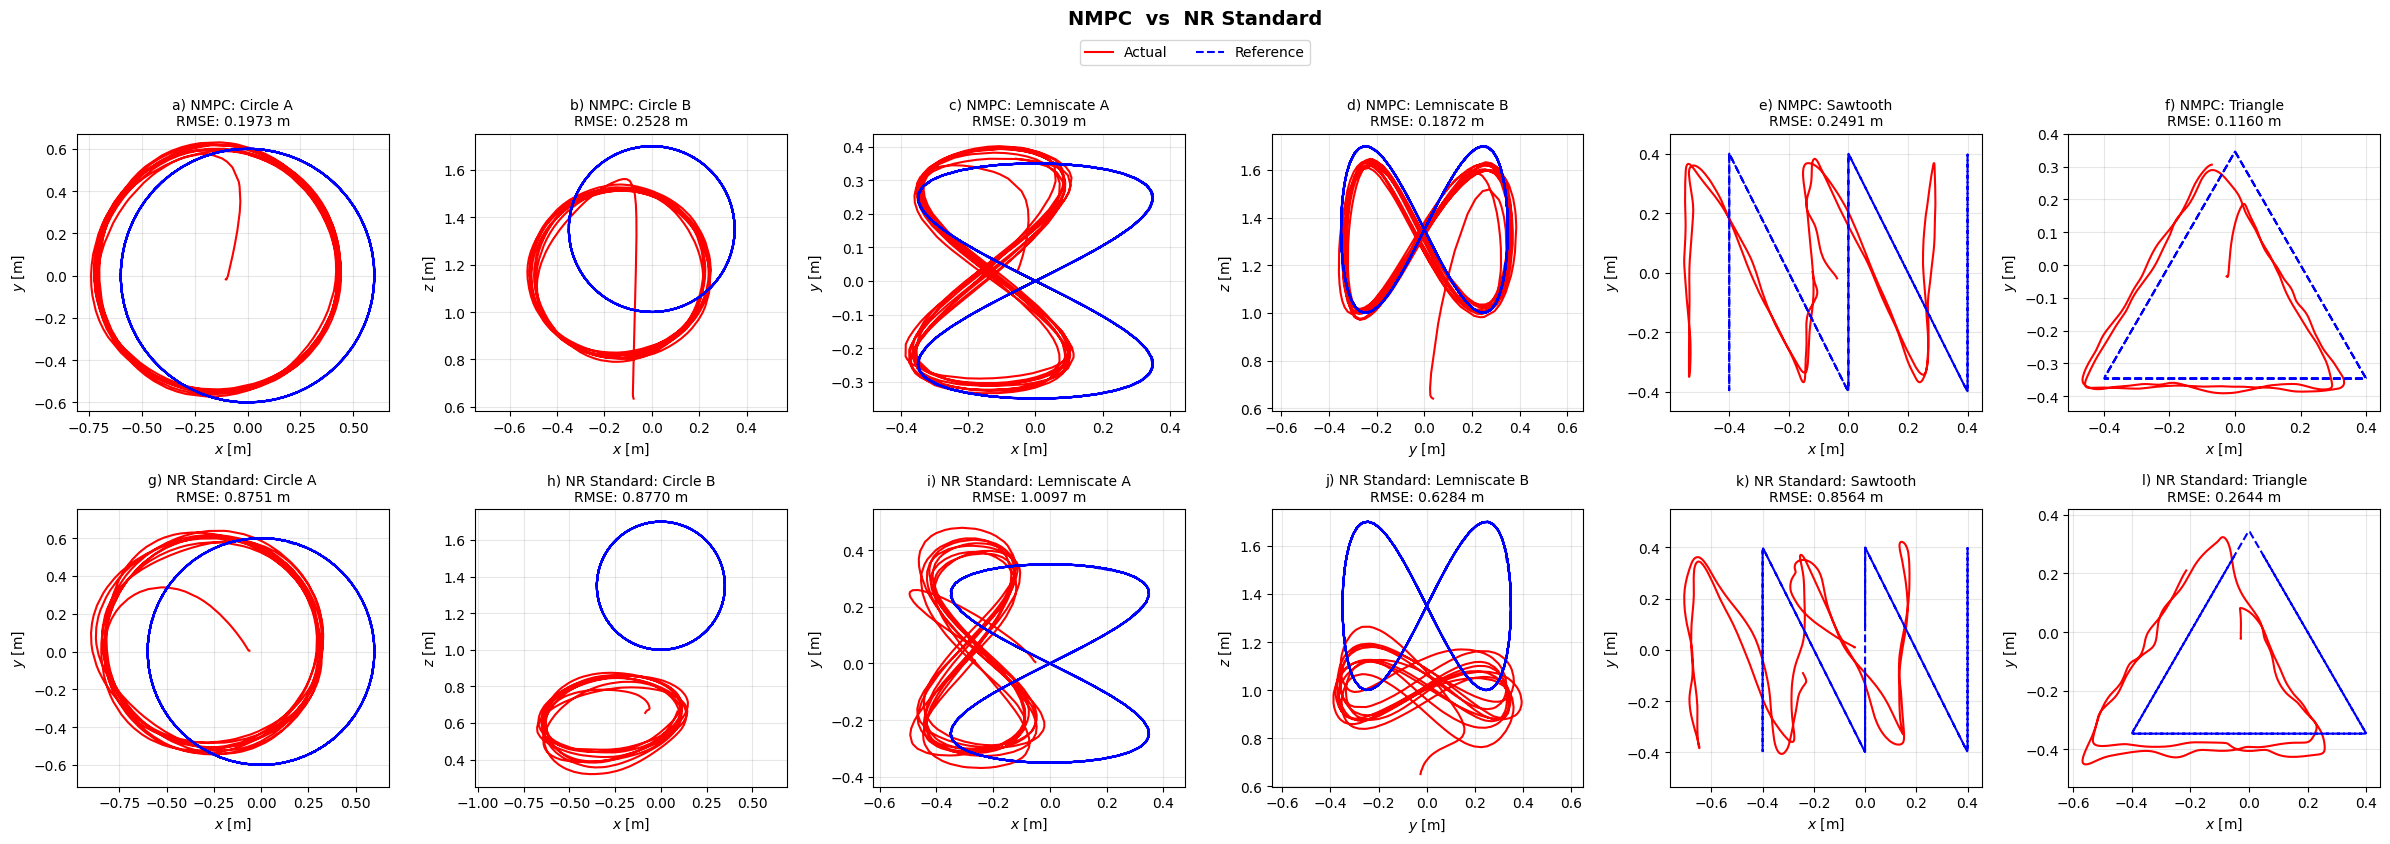

In [5]:
_ = plot_pairwise('NMPC', 'NR Standard', all_data, STANDARD_ORDER, TRAJECTORY_INFO,
                  save_name='comparison_nmpc_vs_nr_standard.pdf')

## 5. NMPC vs NR Enhanced

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Saved: output/comparison_nmpc_vs_nr_enhanced.pdf


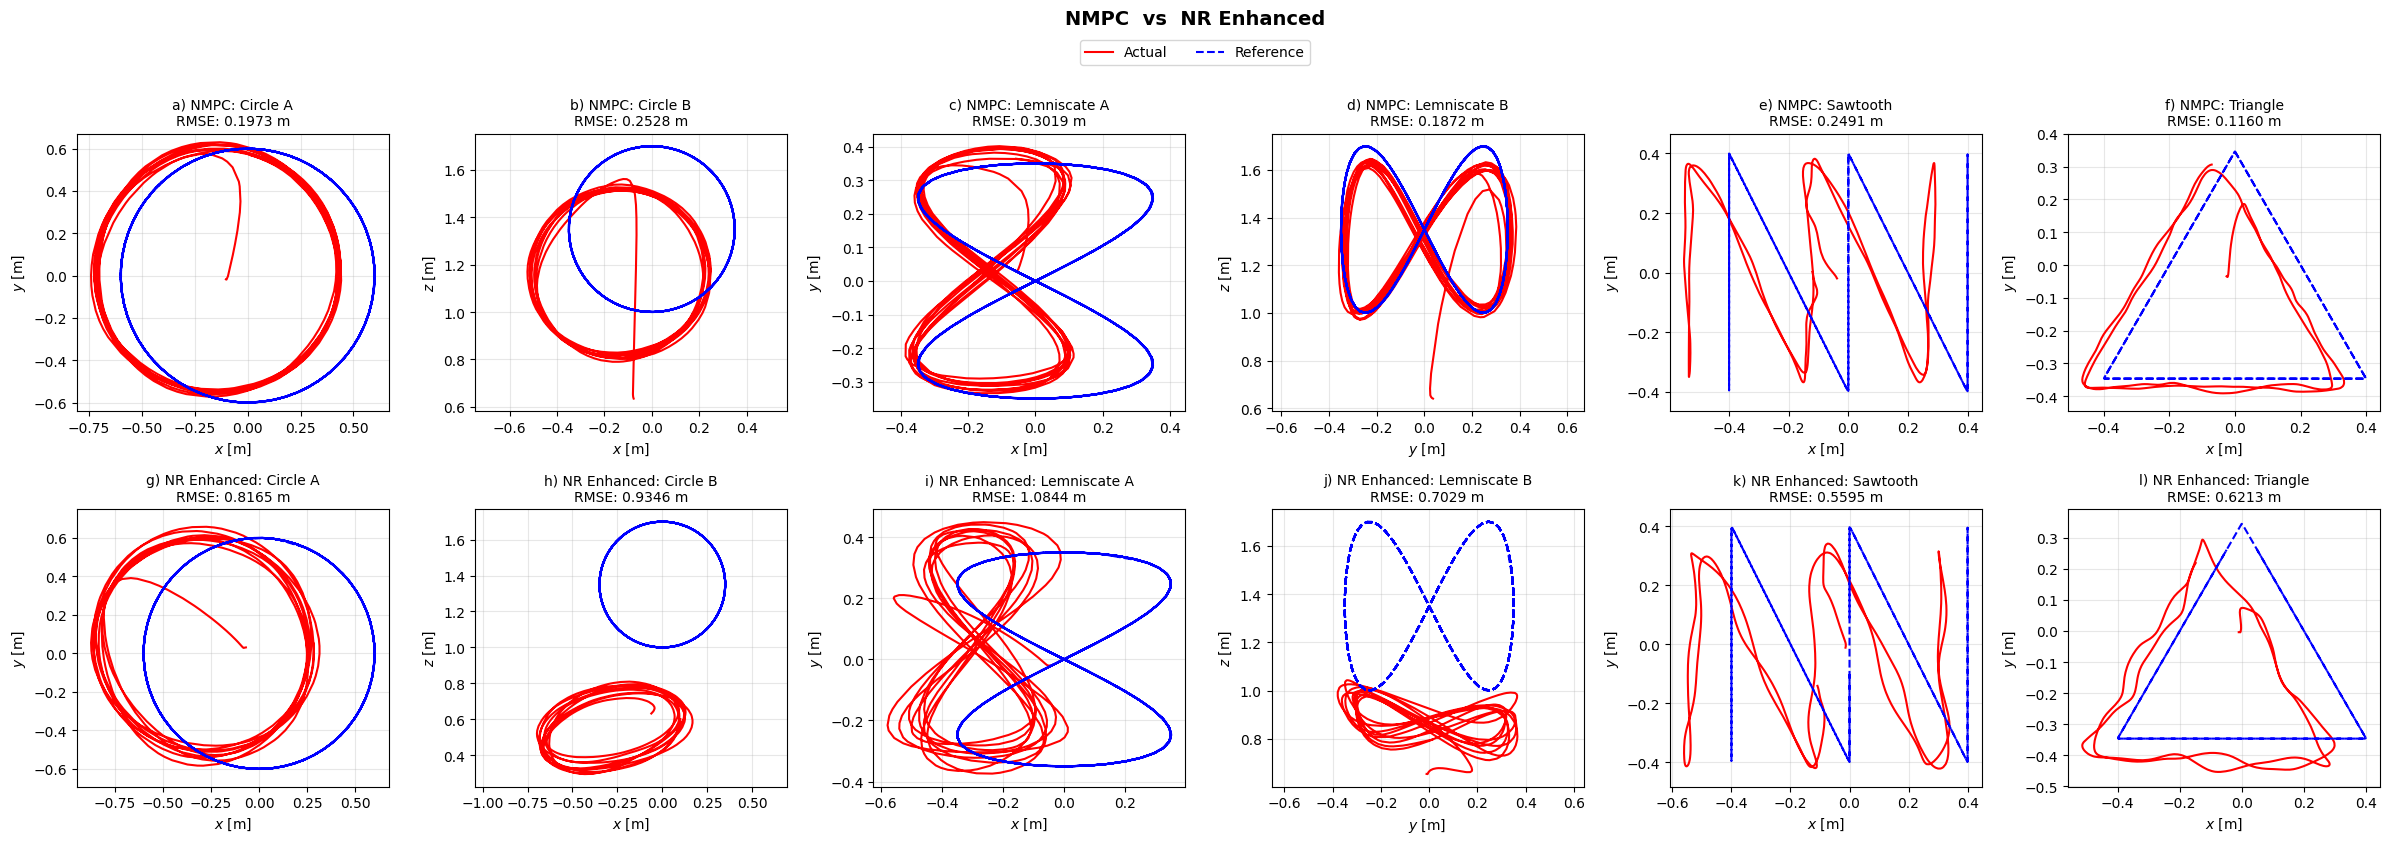

In [6]:
_ = plot_pairwise('NMPC', 'NR Enhanced', all_data, STANDARD_ORDER, TRAJECTORY_INFO,
                  save_name='comparison_nmpc_vs_nr_enhanced.pdf')

## 6. NR Standard vs NR Enhanced

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Saved: output/comparison_nr_standard_vs_nr_enhan

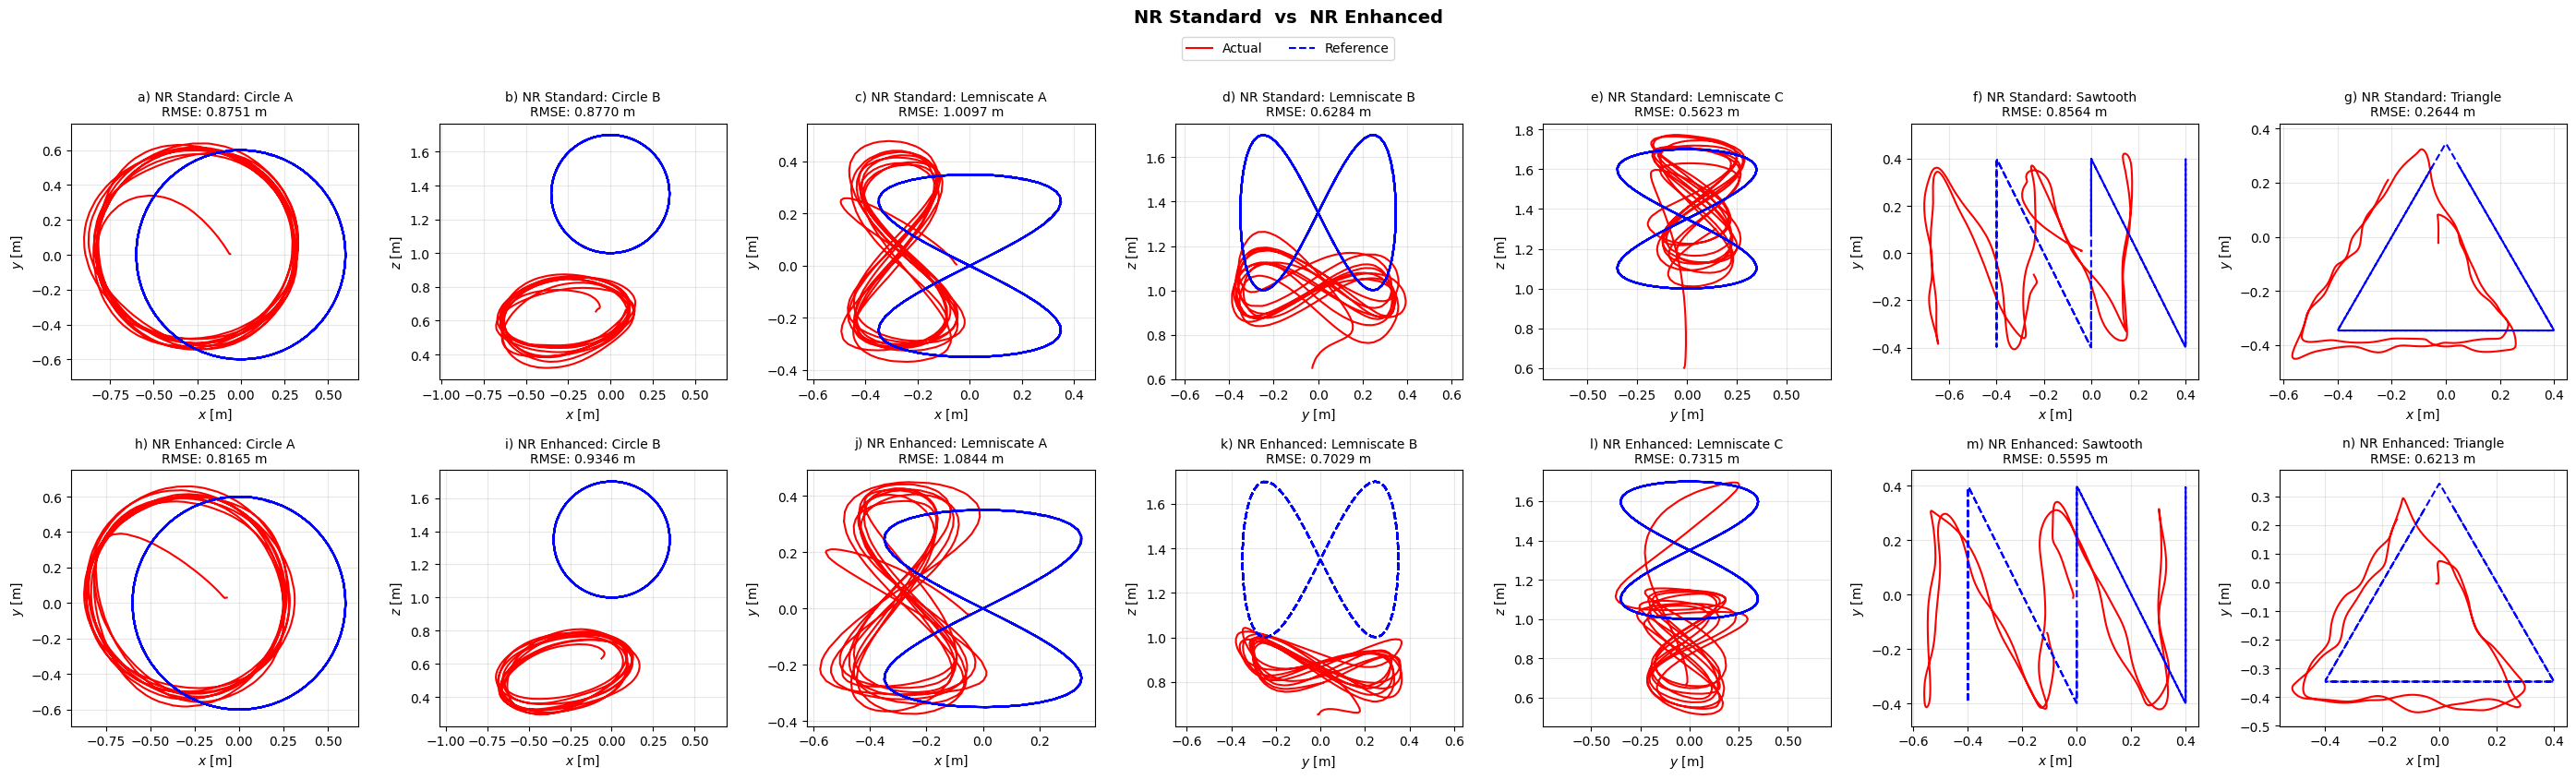

In [7]:
_ = plot_pairwise('NR Standard', 'NR Enhanced', all_data, STANDARD_ORDER, TRAJECTORY_INFO,
                  save_name='comparison_nr_standard_vs_nr_enhanced.pdf')

## 7. All Three Controllers

3 rows (NMPC / NR Standard / NR Enhanced) by N columns (one per common trajectory).
Each column shows the same trajectory for easy visual comparison.

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Saved: output/comparison_all_three_controllers.pdf


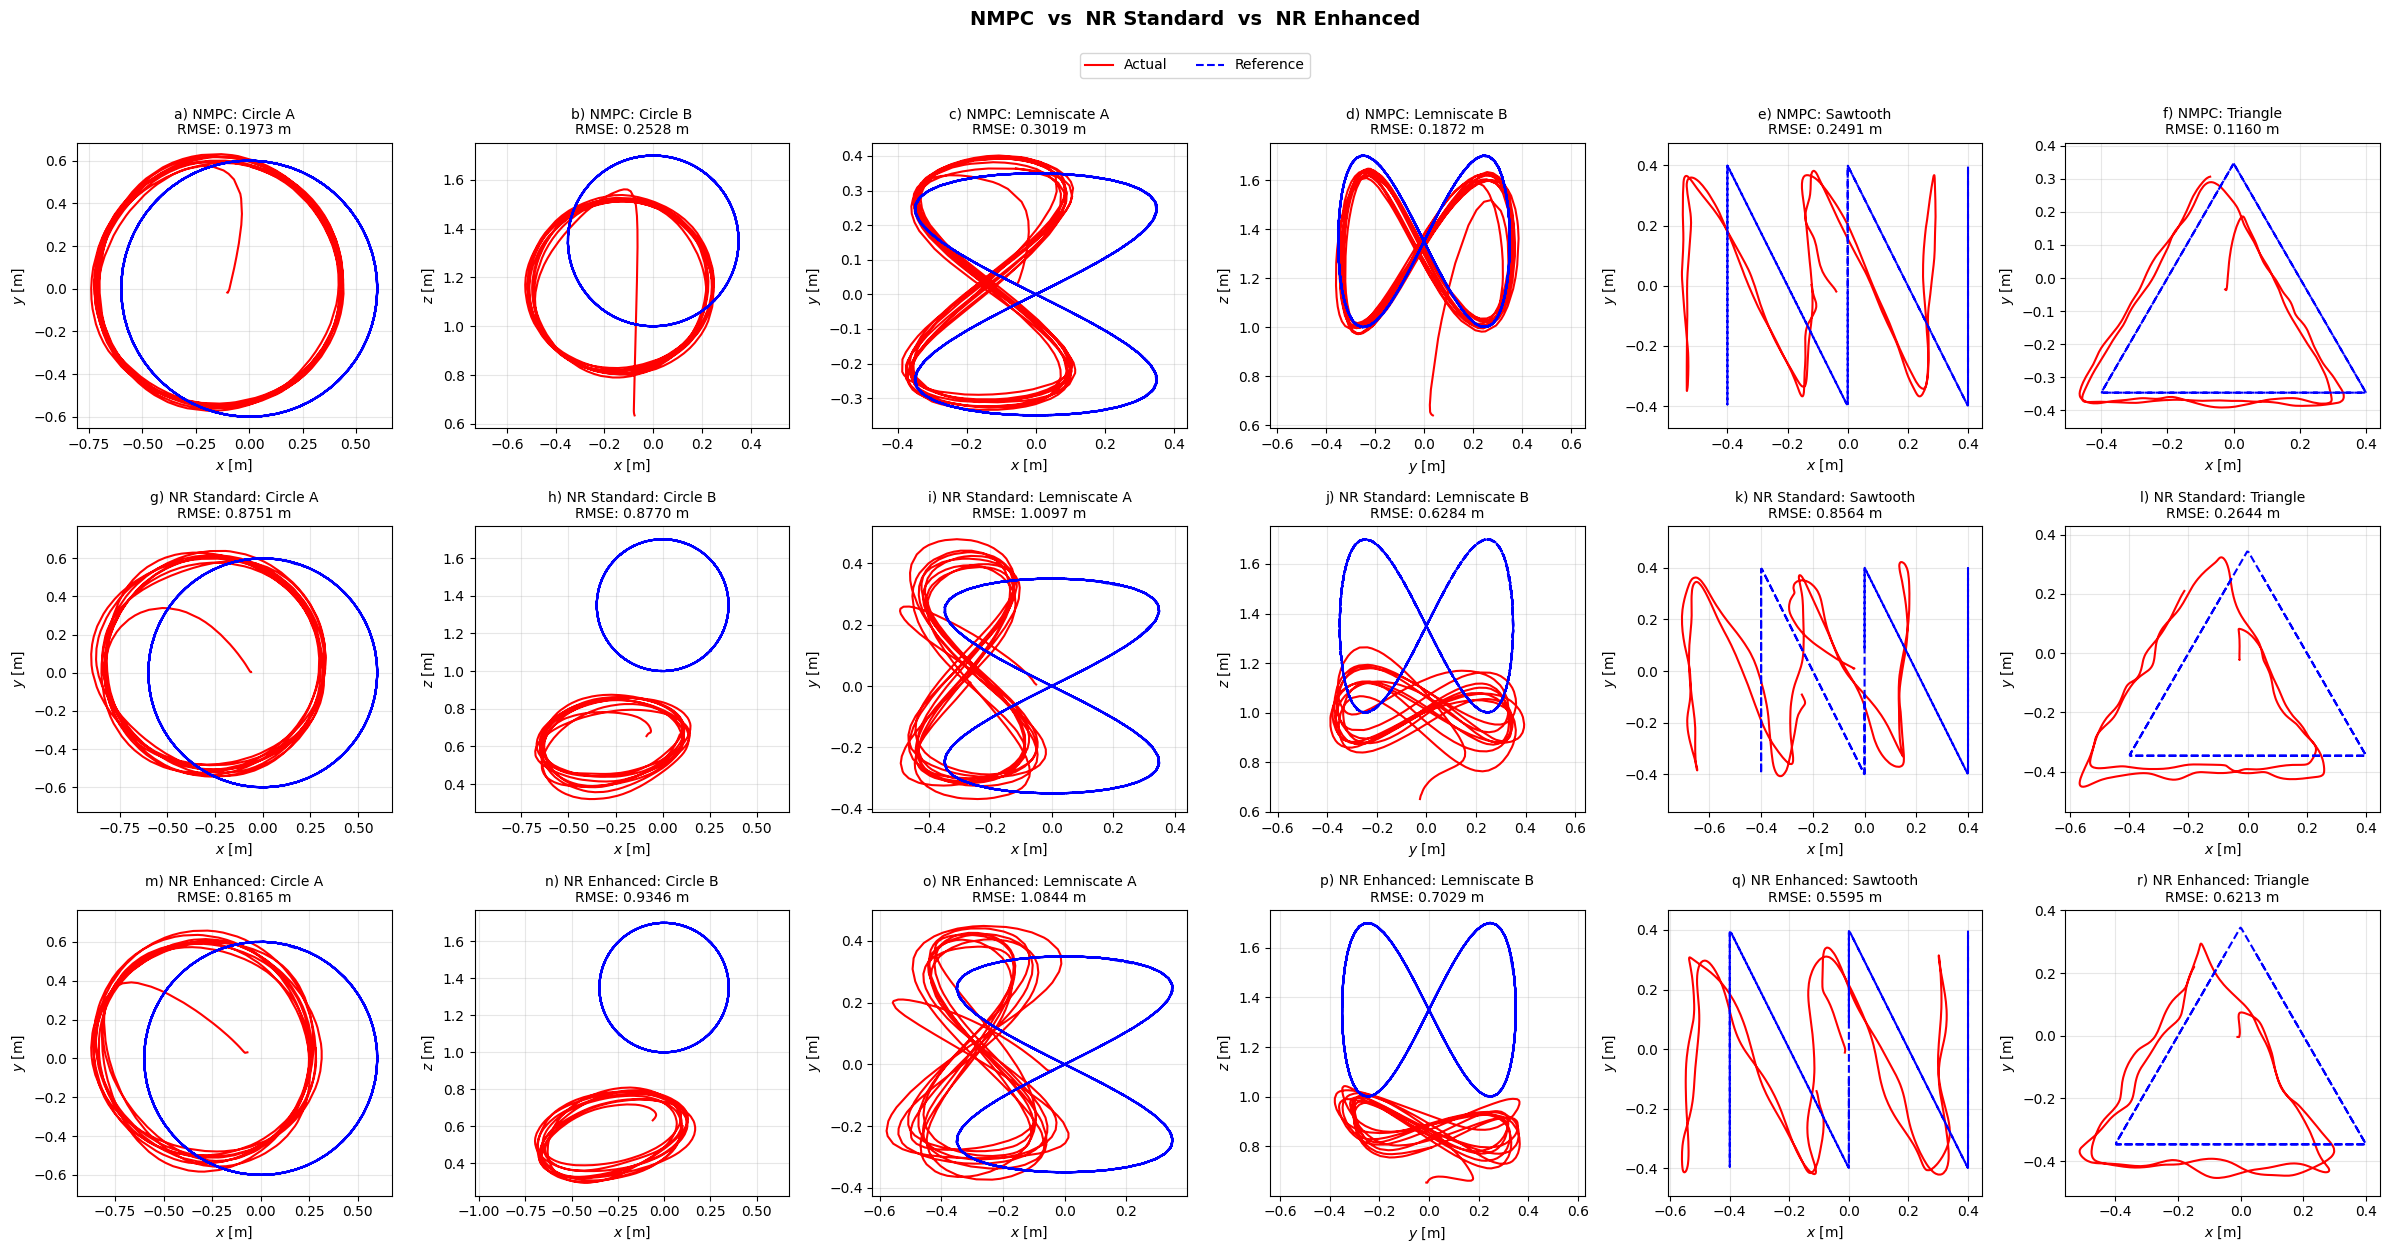

In [8]:
ctrls = ['NMPC', 'NR Standard', 'NR Enhanced']
common = [k for k in STANDARD_ORDER if all(k in all_data[c] for c in ctrls)]
n = len(common)

if n == 0:
    print("No common trajectories across all three controllers.")
else:
    fig, axes = plt.subplots(3, n, figsize=(4 * n, 12))
    if n == 1:
        axes = axes[:, np.newaxis]

    subplot_idx = 0
    for row, ctrl_name in enumerate(ctrls):
        for col, suffix in enumerate(common):
            ax = axes[row, col]
            info = all_data[ctrl_name][suffix]
            df = info['df'].copy()

            df['z'] = -df['z']
            df['z_ref'] = -df['z_ref']
            df = align_reference_to_actual(df, sampling_rate=10.0)

            plane = detect_trajectory_plane(df)
            plot_trajectory_2d(ax, df, plane=plane, flip_z=False, align_lookahead=False)

            rmse = calculate_position_rmse(df, flip_z=False, align_lookahead=False)
            lbl = chr(ord('a') + subplot_idx); subplot_idx += 1
            ax.set_title(f"{lbl}) {ctrl_name}: {info['name']}\nRMSE: {rmse:.4f} m",
                         fontsize=10)

            leg = ax.get_legend()
            if leg:
                leg.remove()

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2,
               bbox_to_anchor=(0.5, 1.01), fontsize=10)

    fig.suptitle('NMPC  vs  NR Standard  vs  NR Enhanced',
                 fontsize=14, fontweight='bold', y=1.04)
    plt.tight_layout()
    fig.savefig(output_dir / 'comparison_all_three_controllers.pdf',
                bbox_inches='tight', dpi=300)
    print(f"Saved: {output_dir / 'comparison_all_three_controllers.pdf'}")
    plt.show()